# NGC VIDUS and Lung Cancer in Never Smokers OAall GWAS
__Author__: Jesse Marks

This document logs the steps taken to perform an opioid addiction GWAS on [Vancouver Injection Drug Users Study (VIDUS)](http://www.cfenet.ubc.ca/research/vidus) subjects versus all controls of [Lung Cancer in Never Smokers Study](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs000634.v1.p1). The processing performed on these data follow the Heroin NIDA Genetics Consortium (NGC) Protocol. For any general or specific questions regarding this protocol, speak with Eric O. Johnson.

## Software and tools
The software and tools used for processing these data are

* [Amazon Elastic Compute Cloud(EC2)](https://aws.amazon.com/ec2/)
* GNU bash version 4.1.2
* [PLINK v1.9 beta 3.45](https://www.cog-genomics.org/plink/)
* [EIGENSOFT v4.2](https://www.hsph.harvard.edu/alkes-price/software/)
* [R v3.2.3](https://www.r-project.org/)
* R packages: MASS, moments
* [RVtests](https://render.githubusercontent.com/view/ipynb?commit=3bb8e661ad8b75af027ed2748133452ec251aaed&enc_url=68747470733a2f2f7261772e67697468756275736572636f6e74656e742e636f6d2f525449496e7465726e6174696f6e616c2f6271756163685f6e6f7465626f6f6b732f336262386536363161643862373561663032376564323734383133333435326563323531616165642f6865726f696e5f70726f6a6563742f646576656c6f702f32303138303131305f756873325f756873335f666f755f677761732e6970796e623f746f6b656e3d41664d79344e373237626e764465456f46535a697770346b48776246577964706b7335617570495a7741253344253344&nwo=RTIInternational%2Fbquach_notebooks&path=heroin_project%2Fdevelop%2F20180110_uhs2_uhs3_fou_gwas.ipynb&repository_id=105297875&repository_type=Repository)

## Variable information
### NGC Protocol Specifications
* OAall (coded 1 for all controls, 2 for OA cases)
* Sex (coded 1 for female, 2 for male)
* Any additional covariates (coded 1 for no, 2 for yes)
* Age (years)

### VIDUS
__OAall Variables__:

`Opiodcase` <br>
* Identified opioid addiction cases at those with heroin or prescription use >= 2-3 times/week in last six months (= 4 | = 5 in heroin or prescript use – inj or non). Generated 181 cases. Considered possible additional cases from uses of one or more of these at a level of once/week (=3). However, only 12 noncases by the above criteria have FOU in the same range as the cases, all but 1 of which could get the in-range score from a combination of lower frequency use across the multiple variables and still not be using 2-3 times/week. Decided to stick with the 181 as a cleaner case set.

`Female (sex)` <br>
* 0 is male, 1 is female 

`Ageatint` <br>
* Age at time of interview.

__Note__: Eric Johnson supplied the phenotype data for these VIDUS cases.
### Lung Cancer in Never smokers
`Opiodcase` 
* will be zero.

`Gender (sex)`
* 1 is male, 2 is female (need to reverse these for study)

`Age`
* subject age

## Retrieve OAall data
The data have already been filtered to 
* Remove subjects with opioidcase == 0
* Remove duplicate subjects by keeping only the more recent data record
* Remove subjects with previously reported sex discrepancy

These data are located on EC2 at `/shared/sandbox/ngc_vidus-lung_cancer_fou/phenotype/GWAS-Cohort-n938_passed_g_qc_only_opioid_FOU.csv`

* There are 181 subjects in this CASES file.

* I need to filter the original `.fam` file based off of the IDs in the FOU phenotype data.


In [ ]:
### EC2 console ###
mkdir -p /shared/s3/ngc_vidus_oaall/{vidus,lung_cancer}
cd /shared/s3/ngc_vidus_oaall

cp -r ../../sandbox/ngc_vidus-lung_cancer_oaall_case_control/VIDUS/* vidus/
cp -r ../../sandbox/ngc_vidus-lung_cancer_oaall_case_control/lung_cancer/* lung_cancer

cd /shared/s3/ngc_vidus_oaall/vidus/phenotype

# R console on EC2 #
pheno <- read.table("GWAS-Cohort-n938_passed_g_qc_only_opioid_CASES.csv", header=T, sep=',')

pheno_size <- length(pheno[,1])
id_list <- c()

for (i in 1:pheno_size){
    tmp_num <- sprintf("-%04d", pheno[i,1]) 
    id_list <- append(id_list, tmp_num)
}

write(id_list, "id_list.txt", sep="\n")
quit()

In [ ]:
### EC2 console ###
cd /shared/s3/ngc_vidus_oaall/phenotype

# filter the fam file based on the subjects that are in the FOU phenotype data
# this is needed to create the PLINK filtered datasets to run eigenstrat
grep -f id_list.txt ../genotype/original/final/ea_chr_all.fam > filtered.fam
awk '{print $1,$2 }' filtered.fam > ea_subject_ids.keep

# get covariates
awk 'BEGIN{FS=","; OFS="\t"} {print $1,$2,$17,$20}' GWAS-Cohort-n938_passed_g_qc_only_opioid_CASES.csv > ea_CASES.data
head ea_CASES.data
"""
gwas_code       female  ageatint        opioidcase
3       0       55      1
5       0       40      1
6       1       35      1
11      1       56      1
13      0       35      1
17      0       34      1
18      0       39      1
19      0       29      1
20      0       37      1
"""

# map sex code and gwas_code
awk 'NR==FNR{ map[NR]=$1;next } FNR==1{print $0} FNR>=2 {$1=map[FNR-1];print $0}' id_list.txt ea_CASES.data > ea_cases_map.data
awk '{ if( $2==0) { $2=2} {print $0}} ' ea_cases_map.data > temp && mv temp ea_cases_map.data && rm temp

# make sure there are no missing data for sex, FOU, or age
# Note that the phenotype data were already filtered. If they
# had not been, we would check for this. I did a visual inspection for 
# a sanity check though.

In [ ]:
### R console ###
library(MASS)
options(repr.plot.width=10, repr.plot.height=17)
# note that I copied over the phenotype data to my local machine to produce the plots
setwd('C:/Users/jmarks/Desktop/VIDUS/oaall/pheno/')

ea.cases.data <- read.table("ea_cases_map.data", header = T, colClasses = c("character", rep("integer",  3)) )
table(ea.cases.data$female)

## Combine cases and controls

### Filter vidus subjects based off case status

In [ ]:
### EC2 console ###
mkdir /shared/s3/ngc_vidus_oaall/vidus/genotype/original/final/filtered
cd /shared/s3/ngc_vidus_oaall/vidus/

# Remove vidus subjects by phenotype criteria (case status)
ancestry="ea"
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile genotype/original/final/ea_chr_all \
    --keep phenotype/ea_subject_ids.keep \
    --make-bed \
    --out genotype/original/final/filtered/${ancestry}_cases

### Merge test

To determine whether any of the SNPs are flipped between studies, a merge is attempted. If any multi-allelic variants are identified (suggestive of flipping) then an error is raised. In this case, position duplicates were identified, but these will be removed during the SNP intersection step.

In [ ]:
# EC2 command line #
mkdir -p /shared/s3/ngc_vidus_oaall/{intersect,merged}/merge_test
cd /shared/s3/ngc_vidus_oaall/merged

# Attempt data set merge
ancestry="ea"
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ../lung_cancer/genotype/original/final/ea_chr_all \
    --bmerge ../vidus/genotype/original/final/filtered/${ancestry}_cases \
    --make-bed \
    --out merge_test/merged_unflipped
'Error: 25 variants with 3+ alleles present.'

ancestry="ea"
studies=(lung_cancer vidus) # array of study names

# Get first intersection set
file1=/shared/s3/ngc_vidus_oaall/${studies[0]}/genotype/original/final/${ancestry}_chr_all.bim
file2=/shared/s3/ngc_vidus_oaall/${studies[1]}/genotype/original/final/filtered/${ancestry}_cases.bim
echo -e "\nCalculating intersection between ${file1} and ${file2}...\n"
comm -12 <(cut -f 2,2 $file1 | sort -u) <(cut -f 2,2 $file2 | sort -u) \
    > ../intersect/${ancestry}_variant_intersection.txt

wc -l ../intersect/ea_variant_intersection.txt
'628804 intersect/ea_variant_intersection.txt'

cd ../
# Make new PLINK binary file set for lung_cancer
study="lung_cancer"
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile /shared/s3/ngc_vidus_oaall/${study}/genotype/original/final/${ancestry}_chr_all \
    --extract intersect/${ancestry}_variant_intersection.txt \
    --exclude merge_test/merged_unflipped-merge.missnp \
    --make-bed \
    --out intersect/${study}_${ancestry}
'--extract: 628804 variants remaining.
--exclude: 628779 variants remaining.'


study="vidus"
# Make new PLINK binary file set for vidus
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile /shared/s3/ngc_vidus_oaall/${study}/genotype/original/final/filtered/${ancestry}_cases \
    --extract intersect/${ancestry}_variant_intersection.txt \
    --exclude merge_test/merged_unflipped-merge.missnp \
    --make-bed \
    --out intersect/${study}_${ancestry}


'--extract: 628804 variants remaining.
--exclude: 628779 variants remaining.'

### Second pass merge
To ensure data set compatipatibility, a second pass merge is executed.

In [ ]:
# EC2 command line #
cd /shared/s3/ngc_vidus_oaall/

# Re-attempt data set merge
ancestry="ea"
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile intersect/lung_cancer_ea \
    --bmerge intersect/vidus_ea \
    --make-bed \
    --out merge_test/merged_intersect

# Clean-up
rm -r merge_test

No errors after this 2nd pass merge

## Assign Cases and Controls

In [ ]:
# EC2 command line #
cd /shared/s3/ngc_vidus_oaall/

# assign case or control status in fam file (1=control 2=case)

ancestry="ea"
study1=lung_cancer
study2=vidus

# Modify FAM file to include case/control status
awk '{ $6=1; print $0 }' intersect/${study1}_${ancestry}.fam \
    > intersect/${study1}_${ancestry}_control.fam
awk '{ $6=2; print $0 }' intersect/${study2}_${ancestry}.fam \
    > intersect/${study2}_${ancestry}_case.fam

## EIGENSTRAT
To obtain principal component covariates to use in the GWAS statistical model, EIGENSTRAT is run on LD-pruned observed genotypes for each ancestry group. Usually a GRCh37 plus strand check is implemented, as well as a monomorphic SNP filter and discordant allele flip. Since this was already done for data in preparation for haplotype phasing, the haplotype phasing input PLINK files will be used. Note: In addition to these aforementioned data processing steps, ambiguous SNPs identified by reference panel frequency differences in the discordant allele checks were also removed prior to phasing.

### PLINK file set merge and MAF filter
* Combine the PLINK file sets to form a cases+controls PLINK fileset

In [ ]:
### EC2 console ###
mkdir /shared/s3/ngc_vidus_oaall/eigenstrat
cd /shared/s3/ngc_vidus_oaall/

ancestry="ea"
study1=lung_cancer
study2=vidus

# Create temporary file sets
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --fam intersect/${study1}_${ancestry}_control.fam \
    --bim intersect/${study1}_${ancestry}.bim \
    --bed intersect/${study1}_${ancestry}.bed \
    --make-bed \
    --out eigenstrat/${study1}_${ancestry}.tmp
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --fam intersect/${study2}_${ancestry}_case.fam \
    --bim intersect/${study2}_${ancestry}.bim \
    --bed intersect/${study2}_${ancestry}.bed \
    --make-bed \
    --out eigenstrat/${study2}_${ancestry}.tmp

# Merge file sets
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile eigenstrat/${study1}_${ancestry}.tmp \
    --bmerge eigenstrat/${study2}_${ancestry}.tmp \
    --allow-no-sex \
    --make-bed \
    --out eigenstrat/${study1}_vs_${study2}_${ancestry}_merged.tmp

# MAF > 0.01
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile eigenstrat/${study1}_vs_${study2}_${ancestry}_merged.tmp \
    --maf 0.01 \
    --make-bed \
    --out eigenstrat/${study1}_vs_${study2}_${ancestry}

# Clean up
rm eigenstrat/*.tmp.*

### Remove high-LD region variants

In [ ]:
### EC2 console ###
cd /shared/s3/ngc_vidus_oaall/eigenstrat

ancestry="ea"
study1=lung_cancer
study2=vidus

# Generate list of variants in known high-LD regions
perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' ${study1}_vs_${study2}_${ancestry}.bim \
    > ${study1}_vs_${study2}_${ancestry}.high_ld_regions.remove
            
# Remove SNPs in known high-LD regions
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ${study1}_vs_${study2}_${ancestry} \
    --exclude ${study1}_vs_${study2}_${ancestry}.high_ld_regions.remove \
    --make-bed \
    --out ${study1}_vs_${study2}_${ancestry}_high_ld_regions_removed

### Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of EIGENSTRAT calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using [PLINK --indep-pairwise](https://www.cog-genomics.org/plink/1.9/ld#indep).

In [ ]:
### EC2 console ###
cd /shared/s3/ngc_vidus_oaall/eigenstrat

ancestry="ea"
study1=lung_cancer
study2=vidus

for chr in {1..23}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${study1}_${study2}_${ancestry}_${chr}_ld_prune \
        --script_prefix ${study1}_vs_${study2}_${ancestry}_${chr}_ld_prune \
        --mem 3 \
        --nslots 1 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3000 \
            --bfile ${study1}_vs_${study2}_${ancestry}_high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out ${study1}_vs_${study2}_${ancestry}_chr${chr}_ld_pruned
done

# Merge *prune.in files
ancestry="ea"
study1=lung_cancer
study2=vidus
cat ${study1}_vs_${study2}_${ancestry}_chr*_ld_pruned.prune.in > ${study1}_vs_${study2}_${ancestry}_chr_all_ld_pruned.prune.in

# Create new PLINK filesets with only lD pruned variants
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ${study1}_vs_${study2}_${ancestry} \
    --extract ${study1}_vs_${study2}_${ancestry}_chr_all_ld_pruned.prune.in \
    --make-bed \
    --out ${study1}_vs_${study2}_${ancestry}_ld_pruned

# Clean up
rm *${ancestry}*ld_pruned.{prune.in,prune.out,log}
rm *${ancestry}*ld_prune*qsub*
rm *${ancestry}*high_ld_regions*
rm *${ancestry}*chr23_ld_pruned.hh

### Rename BIM/FAM file IDs
BIM file IDs have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values. FAM file IDs are treated similarly.

## Phenotype visualization
We will copy over the phenotype data from the cloud to our local machine for this visualization section.

In [ ]:
### EC2 console ###
cd /shared/s3/ngc_vidus_oaall/eigenstrat

# Count ID lengths greater than 39 characters
ancestry="ea"
study1=lung_cancer
study2=vidus

awk '{ if(length($1)+length($2)>39){print $2} }' ${study1}_vs_${study2}_${ancestry}_ld_pruned.fam | wc -l
awk '{ if(length($2)>39){print $2} }' ${study1}_vs_${study2}_${ancestry}_ld_pruned.bim | wc -l

# Rename BIM file IDs
#awk '{$2="ID_"NR; print $0}' ${study1}_vs_${study2}_${ancestry}_ld_pruned.bim \
#    > ${study1}_vs_${study2}_${ancestry}_ld_pruned_id_renamed.bim

# Rename FAM file IDs
awk '{$1="ID_"NR; print $0}' ${study1}_vs_${study2}_${ancestry}_ld_pruned.fam \
    > ${study1}_vs_${study2}_${ancestry}_ld_pruned_id_renamed.fam

### Run EIGENSTRAT
__NOTE__: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT `bin` directory should be part of the PATH variable.

The `smartpca.pl` program documentation is shown below:

DOCUMENTATION of `smartpca.pl` program:

This program calls the smartpca program (see ../POPGEN/README). 
For this to work, the bin directory containing smartpca MUST be in your path. 
See `./example.perl` for a toy example.
```
../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.```

In [ ]:
### EC2 console ###
cd /shared/s3/ngc_vidus_oaall/eigenstrat

mkdir results

ancestry="ea"
study1=lung_cancer
study2=vidus

# Run smartpca
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${study1}_${study2}_${ancestry}_smartpca \
    --script_prefix smartpca_${study1}_vs_${study2}_${ancestry} \
    --mem 7.5 \
    --nslots 1 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i ${study1}_vs_${study2}_${ancestry}_ld_pruned.bed \
        -a ${study1}_vs_${study2}_${ancestry}_ld_pruned.bim \
        -b ${study1}_vs_${study2}_${ancestry}_ld_pruned_id_renamed.fam \
        -o results/${study1}_vs_${study2}_${ancestry}_ld_pruned.pca \
        -p results/${study1}_vs_${study2}_${ancestry}_ld_pruned.plot \
        -e results/${study1}_vs_${study2}_${ancestry}_ld_pruned.eval \
        -l results/${study1}_vs_${study2}_${ancestry}_ld_pruned.pca.log \
        -m 0

## PCA Plot

In [ ]:
### local machine ###

# grab data from EC2
cd /cygdrive/c/Users/jmarks/Desktop/Projects/Heroin/ngc/oaall/eigenstrat
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/ngc_vidus_oaall/eigenstrat/results/lung_cancer_vs_vidus_ea_ld_pruned.pca.evec .


In [ ]:
### R console ###
# Load PCA data
setwd("C:/Users/jmarks/Desktop/Projects/Heroin/ngc/oaall/eigenstrat/")
options(stringsAsFactors = F)
ea.evec <- read.table("lung_cancer_vs_vidus_ea_ld_pruned.pca.evec", comment.char="#", sep="", row.names=1)
ea.evec[,1:5]

In [ ]:
### R console ###
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

#Color label samples
sample.names <- ea.evec[,11]
label.colors <- rep(NA, length(sample.names))
label.colors[grepl(x=sample.names, pattern="Case", ignore.case=T)] <- rgb(0,80,190,80, maxColorValue=255) #blue
label.colors[grepl(x=sample.names, pattern="Control", ignore.case=T)] <- rgb(200,0,0,80, maxColorValue=255) #red
legend.cols <- c(rgb(0,80,190,255, maxColorValue=255), rgb(255,0,0,255, maxColorValue=255))

###label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="VIDUS + Controls (LCNS)", cex.main=1)

par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="VIDUS + Controls EA", cex.main=1)
legend("bottom", c("Lung Cancer", "Lymphoma"), 
       pch=19, col=legend.cols,
       xpd=TRUE, horiz=TRUE, inset=c(0,-0.02), 
       bty="n", cex=1)


#--------------------------------------------------------------------------------


### Extract Eigenvectors

In [ ]:
### EC2 console ###
cd /shared/s3/ngc_vidus_oaall/eigenstrat/results

# Grab top 10 eigenvectors from PCA 
ancestry="ea"
study1=lung_cancer
study2=vidus

echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > ${study1}_vs_${study2}_${ancestry}_ld_pruned_top10_eigenvecs.txt
tail -n +2 ${study1}_vs_${study2}_${ancestry}_ld_pruned.pca.evec | \
    perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
    >> ${study1}_vs_${study2}_${ancestry}_ld_pruned_top10_eigenvecs.txt

## Phenotype processing
The covariates we want to include are age and sex. The coding for case-control status will be case=2 and control=1. Sex should be encoded as male=2 and female=1. For the studies being concatenated the coding is currently:

* Lung Cancer: male=1, female=2
* VIDUS: male=0, female=1

These will be corrected to follow the NGC protocol.


__Note__: in the future, need to make sure the subjects for the controls are not missing any phenotype data - i.e. the sex, age, or id. 


Make PED format phenotype and covariate file according to the NGC protocol
### PED file contruction: Controls LCNS

In [ ]:
### EC2 console ###
cd /shared/s3/ngc_vidus_oaall/lung_cancer/phenotype

# copy phenotype file from QC directory
cp /shared/data/studies/phs000634_lung_cancer/phenotype/processing/Subject_Phenotypes.GRU-MDS.txt .
cp /shared/data/studies/phs000634_lung_cancer/phenotype/processing/Subject.MULTI.txt .

# LCNS
tail -n +11 Subject_Phenotypes.GRU-MDS.txt | \
    awk 'BEGIN{OFS="\t"} 
    { print $2,$3,$5}' > lung_cancer_id_sex_age_covar.txt.copy1

# add opioid case status
awk ' NR==1{$3="oaall" } NR>=2{ $3=1} {print $3}' lung_cancer_id_sex_age_covar.txt.copy1 > tmp.file

# combine that column with other covariates
paste lung_cancer_id_sex_age_covar.txt.copy1 tmp.file > lung_cancer_id_sex_age_covar.txt.copy2
rm tmp.file

# copy fam ID
awk '{
if (NR==1)
    {$1="fid"}
{print $1}
}' lung_cancer_id_sex_age_covar.txt.copy2 > fid.file

# map the LCNS fam id to the subject ID 
awk 'BEGIN{ OFS="\t"} NR==FNR{_[$2]=$5;next} $1 in _{$1=_[$1]}1' Subject.MULTI.txt \
    lung_cancer_id_sex_age_covar.txt.copy2 > lung_cancer_id_sex_age_covar.txt.copy3

# map sex to NGC protocol specifications
awk ' BEGIN {OFS="\t"}
{
if ($2==1) 
    {$2=2}
else if ($2==2)
    {$2=1}
}
{print $0}' lung_cancer_id_sex_age_covar.txt.copy3 > lung_cancer_id_sex_age_covar.txt.copy4

# add fam id column back to file
paste fid.file lung_cancer_id_sex_age_covar.txt.copy4 > lung_cancer_id_sex_age_covar.txt.copy5

# change column headers according to NGC protocol
awk 'BEGIN {OFS="\t"}{
if (NR==1)
    {$2="iid"; $3="sex"; $4="age"}
}
{print $0}' lung_cancer_id_sex_age_covar.txt.copy5 > lung_cancer_id_sex_age_covar.txt.copy6

rm lung_cancer_id_sex_age_covar.txt.copy{1..5}
rm fid.file

#### pheno file - VIDUS_NGCW1_EUR_phen.ped

In [ ]:
### R console ###
setwd("/shared/s3/ngc_vidus_oaall/lung_cancer/phenotype")
pheno.data <- read.table("lung_cancer_id_sex_age_covar.txt.copy6", sep = "\t", header = T, stringsAsFactors = F, 
                       colClasses=c("character", "character", "integer", "integer", "integer"))

pca.data <- read.csv("../../eigenstrat/results/lung_cancer_vs_vidus_ea_ld_pruned_top10_eigenvecs.txt", sep = " " , 
                    colClasses=c(rep("character",times=2), rep("double",times = 10)))

ped.file <- data.frame(matrix(ncol = 7, nrow = length(pheno.data[,1])))
colnames(ped.file) <- c("fid", "iid", "patid", "matid", "sex",  "oaall", "age")
ped.file[,1] <- pheno.data[,1]
ped.file[,2] <- pheno.data[,2]
ped.file[,5] <- pheno.data[,3]
ped.file[,6] <- pheno.data[,5]
ped.file[,7] <- pheno.data[,4]

write.table(ped.file[,1:6], "controls_NGCW1_EUR_phen.ped", sep = "\t", row.names = F, quote=F)

#### cov file - VIDUS_NGCW1_EUR_cov.ped

In [ ]:
covar.data <- data.frame(matrix(ncol = 16, nrow = length(pheno.data[,1])))
colnames(covar.data) <- c("fid", "iid", "patid", "matid", "sex", "age", 
                        "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
covar.data[,1:5] <- ped.file[,1:5]
covar.data[,6] <- ped.file[,7]



# matching the PCA data with the 
for (i in 1:length(ped.file[,1])){
    key <- covar.data[i,2]
    
    my_match <- match(key, pca.data[,2])
    covar.data[i,7:length(covar.data)] <- pca.data[my_match, 3:length(pca.data)]
    
} # end i loop

write.table(covar.data, "controls_NGCW1_EUR_cov.ped", quote=FALSE, row.names = FALSE, sep = "\t")

#### Alter iid 
Need to alter the iid in the `cov` and `phen` files to match the iid in the imputed data.

The new `iid` will be of the form: `fid_iid`

In [ ]:
awk ' BEGIN{ OFS="_"} NR>=2{ print $1,$2}' controls_NGCW1_EUR_cov.ped > new_iid
awk ' BEGIN{ OFS="\t"} NR==FNR{ map[NR] = $1;next } FNR>=2{$2 = map[FNR-1]} {print $0 }' new_iid controls_NGCW1_EUR_cov.ped 

### Cases - VIDUS

#### phen file

In [ ]:
### R ###
setwd("/shared/s3/ngc_vidus_oaall/vidus/phenotype")

pheno.data <- read.csv("ea_cases_map.data", sep = "\t", header = T, stringsAsFactors = F, 
                       colClasses=c("character", "integer", "integer", "integer"))

pca.data <- read.csv("../../eigenstrat/results/lung_cancer_vs_vidus_ea_ld_pruned_top10_eigenvecs.txt", sep = " " , 
                    colClasses=c(rep("character",times=2), rep("double",times = 10)))

ped.file <- data.frame(matrix(ncol = 7, nrow = length(pheno.data[,1])))
colnames(ped.file) <- c("fid", "iid", "patid", "matid", "sex",  "oaall", "age")

# cases are the last 182 entries
ped.file[,1] <- pca.data[1997:2177,2]
ped.file[,2] <- pca.data[1997:2177,2]

# map loop (goal to fill in sex and oaall on ped.file)
for (i in 1:length(ped.file[,1])){
    a <- nchar(ped.file[i,1])
    key <- substr(ped.file[i,1], a-4, a)
    
    my_match <- match(key, pheno.data[,1])
    ped.file[i,5] <- pheno.data[my_match,2]
    ped.file[i,6] <- pheno.data[my_match,4]
    ped.file[i,7] <- pheno.data[my_match,3]
    
} # end i loop

write.table(ped.file[,1:6], "cases_VIDUS_NGCW1_EUR_phen.ped", sep = "\t", row.names = F, quote=F)

#### cov file

In [ ]:
covar.data <- data.frame(matrix(ncol = 16, nrow = length(pheno.data[,1])))
colnames(covar.data) <- c("fid", "iid", "patid", "matid", "sex", "age", 
                        "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
covar.data[,1:5] <- ped.file[,1:5]
covar.data[,6] <- ped.file[,7]

# matching the PCA data with the 
for (i in 1:length(ped.file[,1])){
    key <- covar.data[i,2]
    
    my_match <- match(key, pca.data[,2])
    covar.data[i,7:length(covar.data)] <- pca.data[my_match, 3:length(pca.data)]
    
} # end i loop

write.table(covar.data, "cases_NGCW1_EUR_cov.ped", quote=FALSE, row.names = FALSE, sep = "\t")

* note I need to find out which PCAs to use in the GWAS

#### Alter iid 
Need to alter the iid in the `cov` and `phen` files to match the iid in the imputed data.

In [ ]:
# cases
awk '{OFS="_"} { print $2,$2 } ' cases_NGCW1_EUR_phen.ped > new_id

awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
    new_id cases_NGCW1_EUR_phen.ped > phen.tmp && \
    mv phen.tmp cases_NGCW1_EUR_phen.ped
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
    new_id cases_NGCW1_EUR_cov.ped > cov.tmp && \
    mv cov.tmp cases_NGCW1_EUR_cov.ped

rm new_id


# controls
awk '{OFS="_"} { print $2,$2 } ' controls_NGCW1_EUR_phen.ped > new_id

awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR]} { print $0}' \
    new_id controls_NGCW1_EUR_phen.ped > phen.tmp && \
    mv phen.tmp controls_NGCW1_EUR_phen.ped
awk 'BEGIN{OFS="\t"} NR==FNR{ map[NR]=$1; next} FNR>=2{$2=map[FNR] } {print $0}' \
    new_id controls_NGCW1_EUR_cov.ped > cov.tmp && \
    mv cov.tmp controls_NGCW1_EUR_cov.ped

rm new_id

### Merge cases and controls PED files

In [ ]:
### EC2 console ###
cd /shared/s3/ngc_vidus_oaall/data/phenotype

cp ../../vidus/phenotype/cases_NGCW1_EUR_* .
cp ../../lung_cancer/phenotype/controls_NGCW1_EUR_* .

cat cases_NGCW1_EUR_cov.ped > VIDUS_NGCW1_EUR_cov.ped
tail -n +2 controls_NGCW1_EUR_cov.ped >> VIDUS_NGCW1_EUR_cov.ped

cat cases_NGCW1_EUR_phen.ped > VIDUS_NGCW1_EUR_phen.ped
tail -n +2 controls_NGCW1_EUR_phen.ped >> VIDUS_NGCW1_EUR_phen.ped


# make sure the files have a consistent delimiter across the board
awk ' BEGIN{ OFS = "\t" } $1=$1 { print $0 }' VIDUS_NGCW1_EUR_phen.ped > temp && mv temp VIDUS_NGCW1_EUR_phen.ped
awk ' BEGIN{ OFS = "\t" } $1=$1 { print $0 }' VIDUS_NGCW1_EUR_cov.ped > temp && mv temp VIDUS_NGCW1_EUR_cov.ped

rm cases_NGCW1_EUR_*
rm controls*

### Alter code for case status for VIDUS cases

In [ ]:
cd /shared/s3/ngc_vidus_oaall/data/phenotype
 awk ' BEGIN{OFS = "\t"} NR <= 182 && NR >=2 {$6 = 2} {print $0}' VIDUS_NGCW1_EUR_phen.ped >\
    temp && mv temp VIDUS_NGCW1_EUR_phen.ped

## PC Selection
Determine which PCs (eigenvectors) contribute the most influence and include them in the GWAS as covariates. Include the PCs which contribute to at least %75 of the variance.

__Note__: we will perform this on our local machine for convenience.

In [ ]:
$ scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/ngc_vidus_oaall/data/phenotype/* Projects/Heroin/ngc/oaall/phenotype

In [1]:
### R console ###

# Load PCA data
setwd('C:/Users/jmarks/Desktop/Projects/Heroin/ngc/oaall/phenotype')
options(stringsAsFactors=F)
ea.cov.data <- read.delim("VIDUS_NGCW1_EUR_cov.ped", header=T, sep="\t")
ea.phen.data <- read.delim("VIDUS_NGCW1_EUR_phen.ped", header=T, sep="\t")

# Combine PCs and phenotype into one data frame
phen.name <- "oaall"
pc.names <- paste0("PC", 1:10)
ea.data <- merge(x=ea.phen.data[,c("iid",phen.name)], y=ea.cov.data[, c("iid", paste0("PC",1:10))], by="iid")

## Regression analysis
We use a regression model of the general structure
\begin{align}
\text{FOU = PC1 + PC2 + ... + PC10}
\end{align}

In [2]:
# Build model formula
model.str <- paste0(phen.name, " ~ ", paste(pc.names, collapse=" + "))
cat("MODEL FORMULA:\n\n", model.str, "\n")

# Get model fits
lm.fit.ea <- lm(formula=as.formula(model.str), data=ea.data)

# Get sequential (type I) sum of squares
anova.ea <- anova(lm.fit.ea)

# Calculate percent variance explained and sort
ea.pve <- cbind(anova.ea[pc.names,], 
                PVE=round(anova.ea[pc.names, "Mean Sq"]/sum(anova.ea[pc.names, "Mean Sq"])*100, digits=2))
ea.pve.sorted <- ea.pve[order(ea.pve$PVE, decreasing=T),]

# Output regression info
cat("\n\n================ EA group ================")
summary(lm.fit.ea)
ea.pve.sorted

MODEL FORMULA:

 oaall ~ PC1 + PC2 + PC3 + PC4 + PC5 + PC6 + PC7 + PC8 + PC9 + PC10 


================ EA group ================


Call:
lm(formula = as.formula(model.str), data = ea.data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.44862 -0.07556 -0.00563  0.06814  0.51896 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.083145   0.002515 430.613  < 2e-16 ***
PC1          0.057072   0.117364   0.486  0.62682    
PC2          1.605367   0.117362  13.679  < 2e-16 ***
PC3          9.868194   0.117364  84.082  < 2e-16 ***
PC4         -0.193696   0.117362  -1.650  0.09900 .  
PC5          1.435726   0.117362  12.233  < 2e-16 ***
PC6         -5.801138   0.117361 -49.430  < 2e-16 ***
PC7          0.254175   0.117364   2.166  0.03044 *  
PC8         -0.487866   0.117367  -4.157 3.35e-05 ***
PC9         -0.314956   0.117365  -2.684  0.00734 ** 
PC10        -0.069545   0.117364  -0.593  0.55354    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1174 on 2166 degrees of freedom
  (2 observations deleted due to missingness)
M

,Df,Sum Sq,Mean Sq,F value,Pr(>F),PVE
PC3,1,97.377888664,97.377888664,7069.7406344,0.000000e+00,71.54
PC6,1,33.653635410,33.653635410,2443.2905357,0.000000e+00,24.72
PC2,1,2.577168570,2.577168570,187.1052414,6.487391e-41,1.89
PC5,1,2.060871185,2.060871185,149.6214896,2.565479e-33,1.51
PC8,1,0.238007426,0.238007426,17.2795980,3.351871e-05,0.17
PC9,1,0.099194782,0.099194782,7.2016491,7.339093e-03,0.07
PC7,1,0.064608247,0.064608247,4.6906290,3.043634e-02,0.05
PC4,1,0.037486043,0.037486043,2.7215275,9.914823e-02,0.03
PC1,1,0.003348685,0.003348685,0.2431182,6.220130e-01,0.00
PC10,1,0.004836362,0.004836362,0.3511252,5.535387e-01,0.00


## Percent Variance Explained Visualization

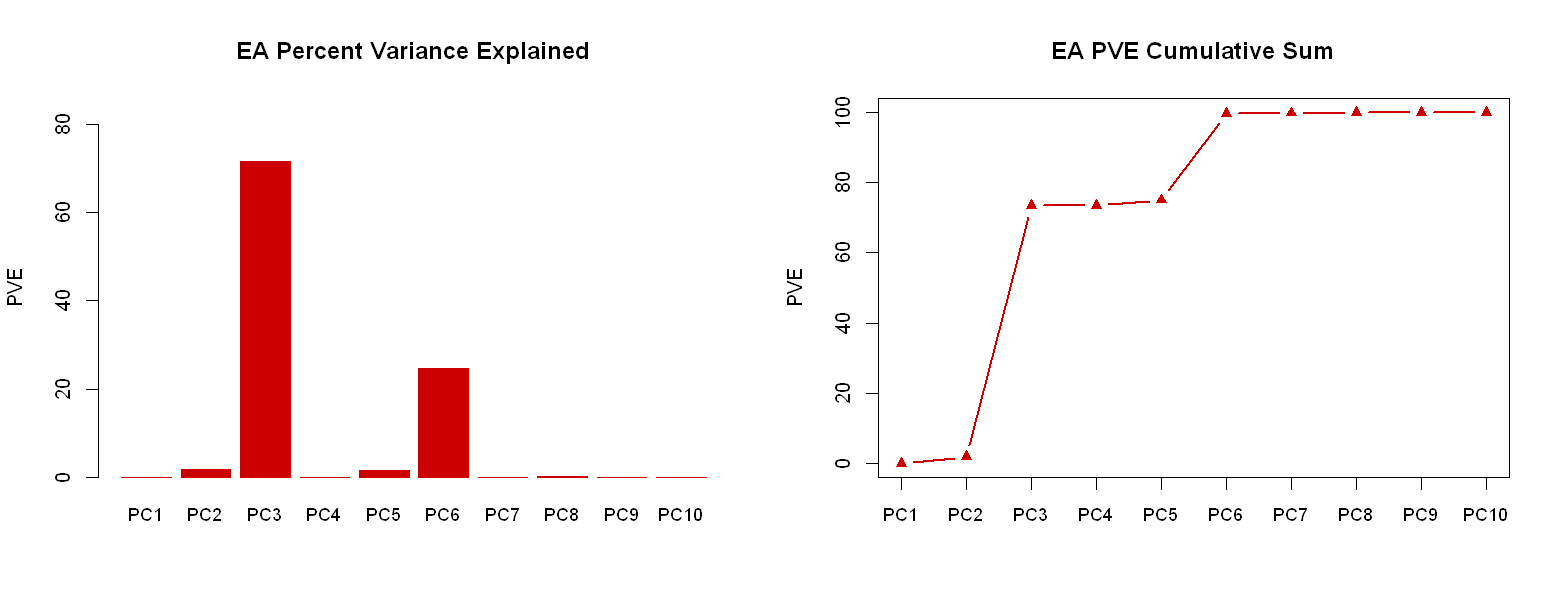

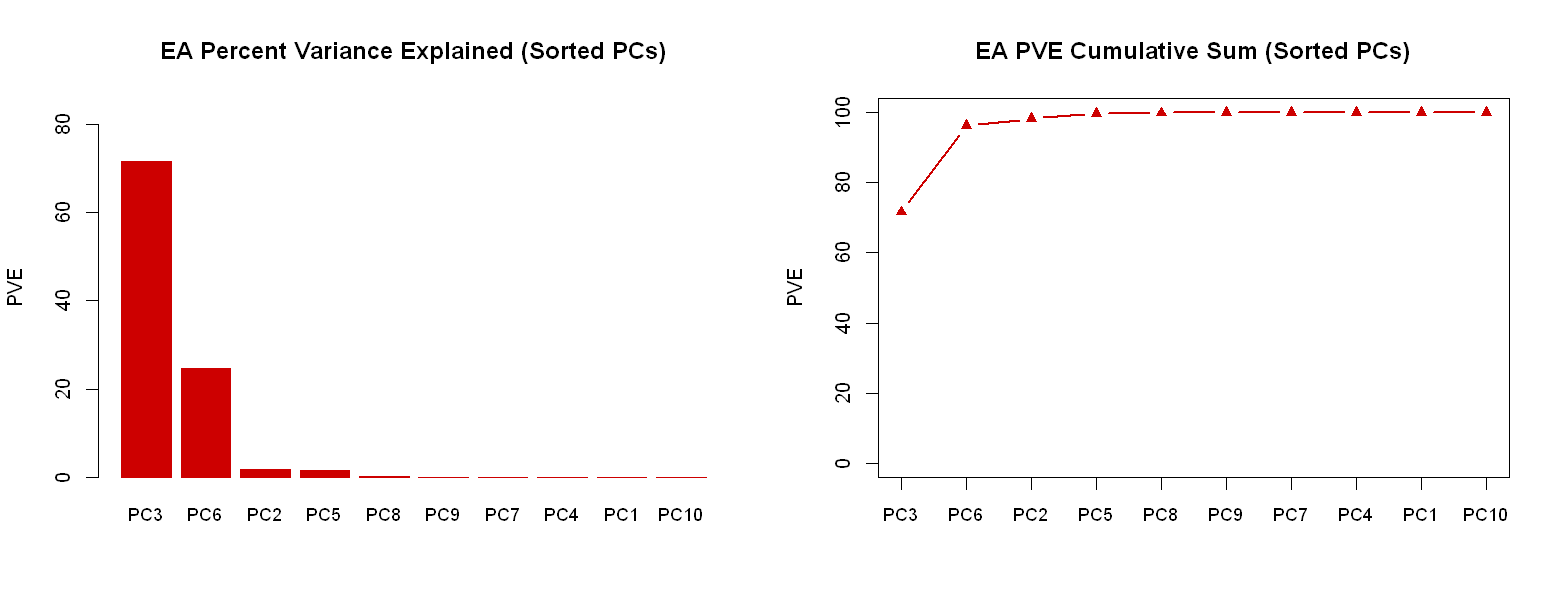

In [3]:
options(repr.plot.width=13, repr.plot.height=5)

# Set graphical parameters
cex.factor = 0.9
barplot.ylim.ea = c(0, max(ea.pve$PVE)*1.2)

# Visualize PVE
par(mfrow=c(1,2))
barplot(height=ea.pve$PVE, names.arg=rownames(ea.pve), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, 
        main="EA Percent Variance Explained", ylab="PVE")
plot(cumsum(ea.pve$PVE), type="b", main="EA PVE Cumulative Sum", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve), cex.axis=cex.factor)

par(mfrow=c(1,2))
barplot(height=ea.pve.sorted$PVE, names.arg=rownames(ea.pve.sorted), beside=T, cex.names=cex.factor, 
        col="red3", border="red3", ylim=barplot.ylim.ea, main="EA Percent Variance Explained (Sorted PCs)", ylab="PVE")
plot(cumsum(ea.pve.sorted$PVE), type="b", main="EA PVE Cumulative Sum (Sorted PCs)", ylab="PVE", 
     lwd=2, col="red3", pch=17, xaxt="n", xlab="", ylim=c(0,100))
axis(side=1, at=c(1:10), labels=rownames(ea.pve.sorted), cex.axis=cex.factor)


Based on these results we will include PC3 and PC6, which explain ~95 percent of the variance. 

## Run GWAS
### Autosomes

In [ ]:
# inflate chr results
for f in {1..22};do
    echo '#!/bin/bash' > chr_$f.sh
    echo '' >> chr_$f.sh
    echo 'unzip -P ";7J4dgCwGjAiuG" chr_'$f'.zip' >> chr_$f.sh
done

for chr in {1..22}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name inflate_chr${chr} \
        --script_prefix test/chr${chr}_results \
        --mem 5 \
        --priority 0 \
        --program bash chr_${chr}.sh 
done

In [ ]:
# Command line # 
mkdir -p /shared/s3/ngc_vidus_oaall/data/assoc_tests
cd /shared/s3/ngc_vidus_oaall/data


# Run RVtest
ancestry="ea"
for chr in {1..22}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr}_rvtest \
        --script_prefix assoc_tests/${ancestry}_${chr}_rvtest \
        --mem 7.5 \
        --nslots 2 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/rvtests/executable/rvtest \
            --inVcf genotype/imputed/${ancestry}/chr${chr}.dose.vcf.gz \
            --pheno phenotype/VIDUS_NGCW1_EUR_phen.ped \
            --pheno-name oaall \
            --covar phenotype/VIDUS_NGCW1_EUR_cov.ped \
            --covar-name sex,age,PC3,PC6 \
            --xLabel X \
            --meta score \
            --useResidualAsPhenotype \
            --inverseNormal \
            --qtl \
            --dosage DS \
            --out assoc_tests/VIDUS_EUR_1000G_oaall_chr${chr}
done

## Results processing

### Unfiltered results

In [ ]:
### EC2 console ###
cd /shared/s3/ngc_vidus_oaall/data/assoc_tests 

# Concatenate chr results together
ancestry="EUR"
test="oaall"
echo -e "\n\n ======== ${ancestry} ======== \n\n"
for chr in {1..22}; do
    zgrep -P "^${chr}\s" VIDUS_${ancestry}_1000G_${test}_chr${chr}.MetaScore.assoc.gz
done |
    gzip -c > VIDUS_${ancestry}_1000G_${test}.gz

# Make results table
ancestry="EUR"
outfile=VIDUS_${ancestry}_1000G_${test}.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
infile=VIDUS_${ancestry}_1000G_${test}.gz
echo "Processing ${infile}"
zcat ${infile} | \
    perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                } else {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                }' >> $outfile

# Make Q-Q and manhattan plots
ancestry=EUR
# Plot all chromosomes
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix VIDUS_${ancestry}_1000G_${test}.assoc.plot \
    --mem 30.6 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in VIDUS_${ancestry}_1000G_${test}.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out VIDUS_${ancestry}_1000G_${test}.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda

In [ ]:
### local machine ###
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/ngc_vidus_oaall/data/assoc_tests/VIDUS_EUR_1000G_oaall.assoc.plot.all_chr.snps+indels.* Projects/Heroin/ngc/oaall/plots/nonfiltered             

### MAF > 0.01 and imputation quality > 0.3

In [ ]:
### EC2 console ###
cd /shared/s3/ngc_vidus_oaall/data/assoc_tests 

# Get list of variants to filter by imputation quality
ancestry="ea"
for chr in {1..22}; do
    echo -e "${ancestry} chr${chr}..."
    zcat ../genotype/imputed/ea/chr${chr}.info.gz | \
        tail -n +2 | \
        awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
        > ${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep
done

# Filter results files
study="oaall"
ancestry=ea
ancestry=EUR
for chr in {1..22}; do
    echo "chr${chr}..."
    awk '{ if(NR==FNR){ map[$1]=1; next } { if(map[$1":"$2":"$3":"$4]==1){ print $0 } } }' \
        ea_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep \
        <(zgrep -P "^${chr}\s" VIDUS_${ancestry}_1000G_${study}_chr${chr}.MetaScore.assoc.gz) \
        > VIDUS_${ancestry}_1000G_${study}_chr${chr}.tmp
done 
cat VIDUS_${ancestry}_1000G_${study}_chr*tmp | gzip -c > VIDUS_${ancestry}_1000G_${study}_maf_gt_0.01_rsq_gt_0.3.gz

# Clean up
rm *tmp

# Make results table
ancestry="EUR"
outfile=VIDUS_${ancestry}_1000G_${study}_maf_gt_0.01_rsq_gt_0.3.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
infile=VIDUS_${ancestry}_1000G_${study}_maf_gt_0.01_rsq_gt_0.3.gz
echo "Processing ${infile}"
zcat ${infile} | \
    perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                } else {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                }' >> $outfile

# Make Q-Q and manhattan plots
ancestry="EUR"
# Plot all chromosomes
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix VIDUS_${ancestry}_1000G_${study}_maf_gt_0.01_rsq_gt_0.3.assoc.plot \
    --mem 30.6 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in VIDUS_${ancestry}_1000G_${study}_maf_gt_0.01_rsq_gt_0.3.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out VIDUS_${ancestry}_1000G_${study}_maf_gt_0.01_rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda

In [ ]:
### local machine ###
scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/s3/ngc_vidus_oaall/data/assoc_tests/VIDUS_EUR_1000G_maf_gt_0.01_rsq_gt_0.3_oaall.assoc.plot.all_chr.snps+indels.* Projects/Heroin/ngc/oaall/plots/filtered             

## PCA Plots
The NGC protocol calls for the submission of the samples projected onto 1000G superpopulation PCA space (EUR, AFR, EAS).

In [ ]:
mkdir -p /shared/s3/ngc_vidus_oaall/cohort_projected_on_1000g/1000g
cd /shared/s3/ngc_vidus_oaall/cohort_projected_on_1000g

# copy study data 
cp ../eigenstrat/lung_cancer_vs_vidus_ea_ld_pruned.fam ./ea_ld_pruned.fam
cp ../eigenstrat/lung_cancer_vs_vidus_ea_ld_pruned.bed ./ea_ld_pruned.bed
cp ../eigenstrat/lung_cancer_vs_vidus_ea_ld_pruned.bim ./ea_ld_pruned.bim
awk '{print $2}' ea_ld_pruned.bim > all_pruned_variant_ids


cd 1000g
# Rename 1000G autosome variant IDs
ancestry=ea
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name recode_to_1000g_${chr} \
        --script_prefix ${ancestry}_chr${chr}_id_rename \
        --mem 8 \
        --nslots 1 \
        --priority 0 \
        --program /shared/bioinformatics/software/perl/id_conversion/convert_to_1000g_p3_ids.pl \
        --file_in /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr}.bim \
        --file_out chr${chr}_renamed.bim \
        --legend /shared/data/ref_panels/1000G/2014.10/1000GP_Phase3_chr$chr.legend.gz \
        --file_in_header 0 \
        --file_in_id_col 1 \
        --file_in_chr_col 0 \
        --file_in_pos_col 3 \
        --file_in_a1_col 4 \
        --file_in_a2_col 5 \
        --chr ${chr}
done

# get list of all variant IDs
touch all_1000g_variants_renamed
for chr in {1..22};do
awk '{ print $2 }' chr${chr}_renamed.bim >> all_1000g_variants_renamed
done

sort all_1000g_variants_renamed > all_1000g_variants_renamed_sorted
sort all_pruned_variant_ids > all_study_variants_renamed_sorted &


# get overlap between 1000g variants and study variants (pruned)
comm -12 ../all_study_variants_renamed_sorted all_1000g_variants_renamed_sorted > ../variant_overlap

# Get subject IDs by ancestry
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="African"){print $1,$1} }'  /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > 1000g_subject_IDs
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="East Asian"){print $1,$1} }'  /shared/data/ref_panels/1000G/igsr_samples.tsv \
    >> 1000g_subject_IDs
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="European"){print $1,$1} }' /shared/data/ref_panels/1000G/igsr_samples.tsv \
    >> 1000g_subject_IDs



# create binary filesets with ld pruned snps
for chr in {1..22}; do
    /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name chr${chr}_filter \
        --script_prefix ancestry_partition_chr${chr} \
        --mem 8 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink  \
            --noweb \
            --memory 10000 \
            --bim chr${chr}_renamed.bim \
            --fam /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr}.fam \
            --bed /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr}.bed \
            --bfile /shared/data/ref_panels/1000G/2013.05/plink/ALL.chr${chr} \
            --keep 1000g_subject_IDs \
            --extract ../variant_overlap \
            --make-bed \
            --out 1000g_chr${chr}_ld_pruned
done

touch autosome_merge_list.txt
for chr in {1..22};do
   echo "1000g_chr${chr}_ld_pruned" >> autosome_merge_list.txt
done

# merge 1000g autosomes
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name merge_plink_filesets \
    --script_prefix merge_plink_filesets \
    --mem 4 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
        --noweb \
        --memory 4000 \
        --merge-list autosome_merge_list.txt \
        --snps-only just-acgt \
        --make-bed \
        --out 1000g_all_auto_ld_pruned

cd /shared/s3/ngc_vidus_oaall/cohort_projected_on_1000g

# filter study data to the variants that overlap with 1000g
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ea_ld_pruned \
    --extract variant_overlap \
    --make-bed \
    --out ea_ld_pruned_1000g_overlap

# Attempt merge 1000g with study data. produced 2 snps that were ambiguous (will remove)
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile 1000g/1000g_all_auto_ld_pruned \
    --bmerge ea_ld_pruned_1000g_overlap \
    --snps-only just-acgt \
    --make-bed \
    --out study_and_1000g_combined_ld_pruned


# Exclude ambiguous snps (polymorphic) from study data
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ea_ld_pruned_1000g_overlap \
    --exclude study_and_1000g_combined_ld_pruned-merge.missnp \
    --make-bed \
    --out ea_ld_pruned_1000g_overlap_removed_ambig


# Exclude ambiguous snps (polymorphic) from 1000g data
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile 1000g/1000g_all_auto_ld_pruned \
    --exclude study_and_1000g_combined_ld_pruned-merge.missnp \
    --make-bed \
    --out 1000g/1000g_all_auto_ld_pruned_removed_ambig

# Attempt merge 1000g with study data.
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 4000 \
    --bfile 1000g/1000g_all_auto_ld_pruned_removed_ambig \
    --bmerge ea_ld_pruned_1000g_overlap_removed_ambig \
    --snps-only just-acgt \
    --allow-no-sex \
    --make-bed \
    --out study_and_1000g_combined_ld_pruned_removed_ambig

### Rename BIM/FAM file IDs
BIM file IDs have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause smartpca to throw an error. To resolve this the IDs are replaced by numeric values. FAM file IDs are treated similarly.

In [ ]:
# EC2 command line #
cd /shared/s3/ngc_vidus_oaall/cohort_projected_on_1000g

# Count ID lengths greater than 39 characters
ancestry="ea"

awk '{ if(length($1)+length($2)>39){print $2} }'  study_and_1000g_combined_ld_pruned_removed_ambig.fam| wc -l
awk '{ if(length($2)>39){print $2} }'  study_and_1000g_combined_ld_pruned_removed_ambig.bim | wc -l

## Rename BIM file IDs
#awk '{$2="ID_"NR; print $0}' study_and_1000g_combined_ld_pruned_removed_ambig.bim \
#    > study_and_1000g_combined_ld_pruned_removed_ambig_id_renamed.bim

# Rename FAM file IDs
awk '{$1="ID_"NR; print $0}' study_and_1000g_combined_ld_pruned_removed_ambig.fam \
    > study_and_1000g_combined_ld_pruned_removed_ambig_id_renamed.fam

### Run EIGENSTRAT
__Eigenstrat on LD pruned snps - study & 1000g merged__

__NOTE__: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT `bin` directory should be part of the PATH variable.

The `smartpca.pl` program documentation is shown below:

DOCUMENTATION of `smartpca.pl` program:

This program calls the smartpca program (see ../POPGEN/README). 
For this to work, the bin directory containing smartpca MUST be in your path. 
See `./example.perl` for a toy example.
```
../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.```

In [ ]:
mkdir -p /shared/s3/ngc_vidus_oaall/cohort_projected_on_1000g/results
cd /shared/s3/ngc_vidus_oaall/cohort_projected_on_1000g

# make not a case nor control in fam file
awk '{$6= "-9"} {print $0}' study_and_1000g_combined_ld_pruned_removed_ambig_id_renamed.fam > final.fam

# Run smartpca
/shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name study_vs_1000g_smartpca \
    --script_prefix smartpca_study_vs_1000g_\
    --mem 8 \
    --nslots 2 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i study_and_1000g_combined_ld_pruned_removed_ambig.bed \
        -a study_and_1000g_combined_ld_pruned_removed_ambig.bim \
        -b final.fam \
        -o results/study_and_1000g_ld_snps.pca \
        -p results/study_and_1000g_ld_snps.plot \
        -e results/study_and_1000g_ld_snps.eval \
        -l results/study_and_1000g_ld_snps.pca.log \
        -m 0

In [16]:
dev.off()

png 
  3

### PCA plotting

In [ ]:
### EC2 console ###
cd /shared/s3/ngc_vidus_oaall/cohort_projected_on_1000g/results
 
# Get subject IDs by ancestry
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="African"){print $1} }'  /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > AFR_1000g_subject_IDs
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="East Asian"){print $1} }'  /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > EAS_1000g_subject_IDs
awk 'BEGIN { FS="\t"; OFS="\t" } { if($7=="European"){print $1} }' /shared/data/ref_panels/1000G/igsr_samples.tsv \
    > EUR_1000g_subject_IDs

In [ ]:
### R console ###

setwd("/shared/s3/ngc_vidus_oaall/cohort_projected_on_1000g/results")

# Load PCA data
options(stringsAsFactors=F)
study.vs_1000 <- read.table("study_and_1000g_ld_snps.pca.evec", comment.char="#", sep="", row.names=1)

# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance
dspace <- study.vs_1000[1:10] #transformed dataspace

AFR = scan(file="AFR_1000g_subject_IDs", what=character())
EAS = scan(file="EAS_1000g_subject_IDs", what=character())
EUR = scan(file="EUR_1000g_subject_IDs", what=character())
VIDUS = scan(file="VIDUS_subject_IDs", what=character())
lung_cancer = scan(file="lung_cancer_subject_IDs", what=character())



#Color label samples
sample.names <- row.names(study.vs_1000)
label.colors <- rep(NA, length(sample.names))
label.colors[grepl(x=sample.names, pattern=paste(lung_cancer,collapse="|"), ignore.case=F)] <- rgb(0,0,0,80, maxColorValue=255) #black
label.colors[grepl(x=sample.names, pattern=paste(VIDUS,collapse="|"), ignore.case=F)] <- rgb(255,0,0,80, maxColorValue=255) #red
label.colors[grepl(x=sample.names, pattern=paste(EUR,collapse="|"), ignore.case=F)] <- rgb(0,0,255,80, maxColorValue=255) #blue
label.colors[grepl(x=sample.names, pattern=paste(EAS,collapse="|"), ignore.case=F)] <- rgb(0,255,0,80, maxColorValue=255) #green
label.colors[grepl(x=sample.names, pattern=paste(AFR,collapse="|"), ignore.case=F)] <- rgb(255,215,0,80, maxColorValue=255) #gold
legend.cols <- c(rgb(255,215,0,255, maxColorValue=255), rgb(0,255,0,255, maxColorValue=255), 
                 rgb(0,0,255,255, maxColorValue=255), rgb(255,0,0,255, maxColorValue=255), rgb(0,0,0,255, maxColorValue=255) )

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=dspace[,1:4], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:4), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="VIDUS vs LCNS vs 1000G", cex.main=1)
# make sure the label matches the study. 
legend("bottom", c("AFR", "EAS", "EUR", "VIDUS", "LCNS"), 
       pch=19, col=legend.cols,
       xpd=TRUE, horiz=TRUE, inset=c(0,-0.02), 
       bty="n", cex=1)

## S3 data transfer

In [ ]:
# Copy phenotype data
cd /shared/s3/ngc_vidus_oaall/data/phenotype
aws s3 cp ./ s3://rti-heroin/ngc_vidus_oaall/data/phenotype \
    --recursive --exclude="*" --include="*ped.gz" --quiet &

cd /shared/s3/ngc_vidus_oaall/data/assoc_tests
# Copy association test results
aws s3 cp ./ s3://rti-heroin/ngc_vidus_oaall/results/rvtest/ \
    --recursive --exclude="*" --include="*MetaScore*gz*" --quiet &
aws s3 cp ./ s3://rti-heroin/ngc_vidus_oaall/results/figures/ \
    --recursive --exclude="*" --include="*.png.gz" --quiet &


--------------------------------------------------------------------------------
# copy imputation files
cd /shared/sandbox/ngc_vidus_oaall/genotype/imputed/ea/
for ext in {\"*.log\",\"*.info.gz\",\"*dose.vcf.gz\",\"*dose.vcf.gz.tbi\",\"*.html\",\"*.txt\"}; do
/shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name s3_upload_vidus \
        --script_prefix test_${ext} \
        --mem 5 \
        --nslots 1 \
        --program "aws s3 cp . s3://rti-heroin/ngc_vidus_oaall/data/genotype/imputed/${ancestry}/ \
            --recursive --exclude \"*\" --include $ext "
done